# Predict Daily Minimum Temperatures using Feedforward NN and RNN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Input

### 1. Load the Dataset

In [2]:
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv"
df = pd.read_csv(url, parse_dates=['Date'])
df

,Date,Temp
0,1981-01-01,20.7
1,1981-01-02,17.9
2,1981-01-03,18.8
3,1981-01-04,14.6
4,1981-01-05,15.8
...,...,...
3645,1990-12-27,14.0
3646,1990-12-28,13.6
3647,1990-12-29,13.5
3648,1990-12-30,15.7


### 2. Visualize the Data

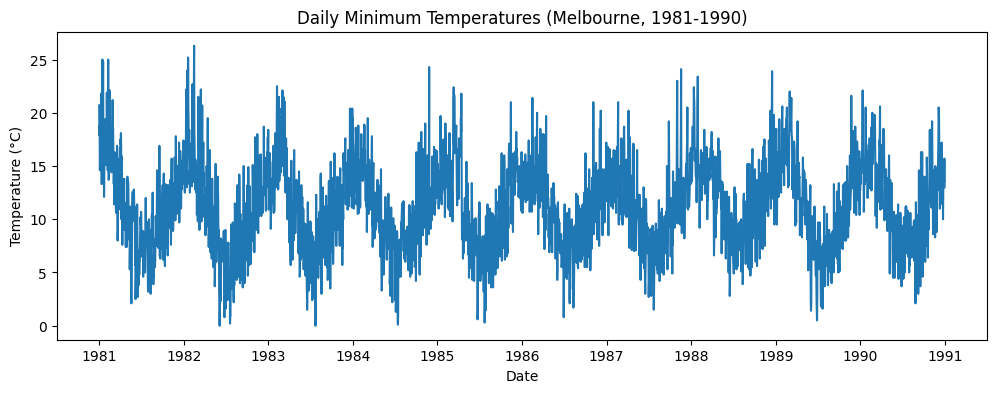

In [3]:
plt.figure(figsize=(12, 4))
plt.plot(df['Date'], df['Temp'])
plt.title('Daily Minimum Temperatures (Melbourne, 1981-1990)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.show()

### 3. Preprocess the Data

In [4]:
temps = df['Temp'].values.reshape(-1, 1)
scaler = MinMaxScaler()
temps_scaled = scaler.fit_transform(temps)

#### Create sequences: use previous N days to predict next day's temp

In [5]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 7  # Use last 7 days to predict next day
X, y = create_sequences(temps_scaled, window_size)

In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Feedforward NN expects 2D input
X_train_ffnn = X_train
X_test_ffnn = X_test

# RNN expects 3D input: [samples, timesteps, features]
X_train_rnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### 4. Build Models

In [7]:
# Feedforward Neural Network
ffnn = Sequential([
    Input(shape=(window_size,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
ffnn.compile(optimizer='adam', loss='mse')

# Simple RNN Model
rnn = Sequential([
    Input(shape=(window_size, 1)),
    SimpleRNN(32, activation='tanh'),
    Dense(1)
])
rnn.compile(optimizer='adam', loss='mse')

### 5. Train the Models

In [8]:
history_ffnn = ffnn.fit(X_train_ffnn, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)
history_rnn = rnn.fit(X_train_rnn, y_train, epochs=30, batch_size=32, validation_split=0.1, verbose=0)

### 6. Evaluate and Compare

In [9]:
# Predict
y_pred_ffnn = ffnn.predict(X_test_ffnn)
y_pred_rnn = rnn.predict(X_test_rnn)

# Inverse scale to get actual temperature values
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_ffnn_actual = scaler.inverse_transform(y_pred_ffnn)
y_pred_rnn_actual = scaler.inverse_transform(y_pred_rnn)

from sklearn.metrics import mean_squared_error

mse_ffnn = mean_squared_error(y_test_actual, y_pred_ffnn_actual)
mse_rnn = mean_squared_error(y_test_actual, y_pred_rnn_actual)

print(f"Feedforward NN Test MSE: {mse_ffnn:.3f}")
print(f"RNN Test MSE: {mse_rnn:.3f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Feedforward NN Test MSE: 5.051
RNN Test MSE: 5.045


### Plot predictions vs actual

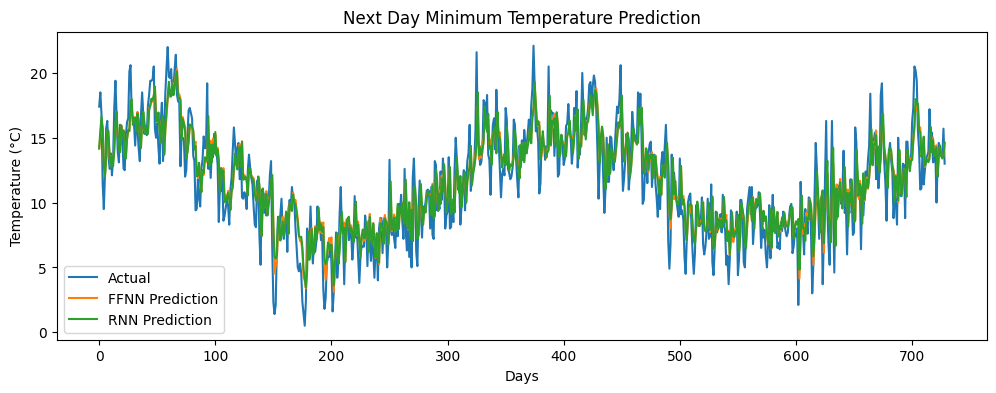

In [10]:
plt.figure(figsize=(12, 4))
plt.plot(y_test_actual, label='Actual')
plt.plot(y_pred_ffnn_actual, label='FFNN Prediction')
plt.plot(y_pred_rnn_actual, label='RNN Prediction')
plt.title('Next Day Minimum Temperature Prediction')
plt.xlabel('Days')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

## Interpreting the Mean Squared Error (MSE) for Temperature Prediction
From the output:

- **Feedforward NN Test MSE:** 5.051  
- **RNN Test MSE:** 5.045

These values represent the average squared error, in degrees Celsius squared, between the predicted and actual minimum temperatures.

### What does this mean in practice?

- Both models performed similarly, with the RNN achieving a slightly lower error.
- To better understand the error, we can calculate the **Root Mean Squared Error (RMSE):**

  \[
  \text{RMSE} = \sqrt{\text{MSE}} \approx \sqrt{5.05} \approx 2.25
  \]

  This means that, on average, the predicted minimum temperature is about **2.25°C away from the actual temperature**.

---

### Is this a good result?

- **Acceptable error** depends on the use case. For daily temperature prediction, an average error of around 2°C may be acceptable for general forecasting, but may not be sufficient for applications requiring high precision.
- **RNNs** are designed to capture temporal patterns, but in this case, both models performed nearly identically. This may be due to the simplicity of the dataset or the model architectures.

---

### Summary Table

| Model            | Test MSE | RMSE (°C) | Notes                                 |
|------------------|----------|-----------|---------------------------------------|
| Feedforward NN   | 5.051    | 2.25      | Slightly higher error                 |
| RNN              | 5.045    | 2.25      | Slightly lower error, similar results |

---

### Conclusion

- Both the feedforward neural network and the RNN predict minimum temperatures with similar accuracy for this dataset.
- The average prediction error is about 2.25°C, which may be acceptable depending on your requirements.
- For more complex time series or longer temporal dependencies, RNNs (or more advanced variants like LSTM/GRU) may offer greater advantages.
